# hw3: Обучение без учителя

*Спасибо ещё одному великому курсу mlcourse.ai и авторам: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS).*

### О задании

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в
задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы, выделив ответ полужирным** (``` **выделить двойными звёздочками** ```).

### Оценивание и штрафы
Вам необходимо ответить на 10 вопросов и выполнить 2 задания. Каждое из заданий и вопросов имеет определенную «стоимость» (указана в скобках). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw3-unsupervised.ipynb``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце "hw3" в строке со своей фамилией о том, что вы выполнили работу и оставить ссылку на ноутбук.


In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm


%matplotlib inline
from matplotlib import pyplot as plt

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
X_train = np.loadtxt("datasets/train/X_train.txt")
y_train = np.loadtxt("datasets/train/y_train.txt").astype(int)

X_test = np.loadtxt("datasets/test/X_test.txt")
y_test = np.loadtxt("datasets/test/y_test.txt").astype(int)

In [4]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*.

In [5]:
# Ваш код здесь
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [9]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [12]:
# Ваш код здесь
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:** (1 балл)

Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

**Варианты:**
- 56
- **65**
- 66
- 193

In [13]:
print(pca.n_components_)

65


**Вопрос 2:** (0.5 баллов)

Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

**Варианты:**
- 45
- **51**
- 56
- 61

In [14]:
print(round(pca.explained_variance_ratio_[0] * 100))

51


Визуализируйте данные в проекции на первые две главные компоненты.

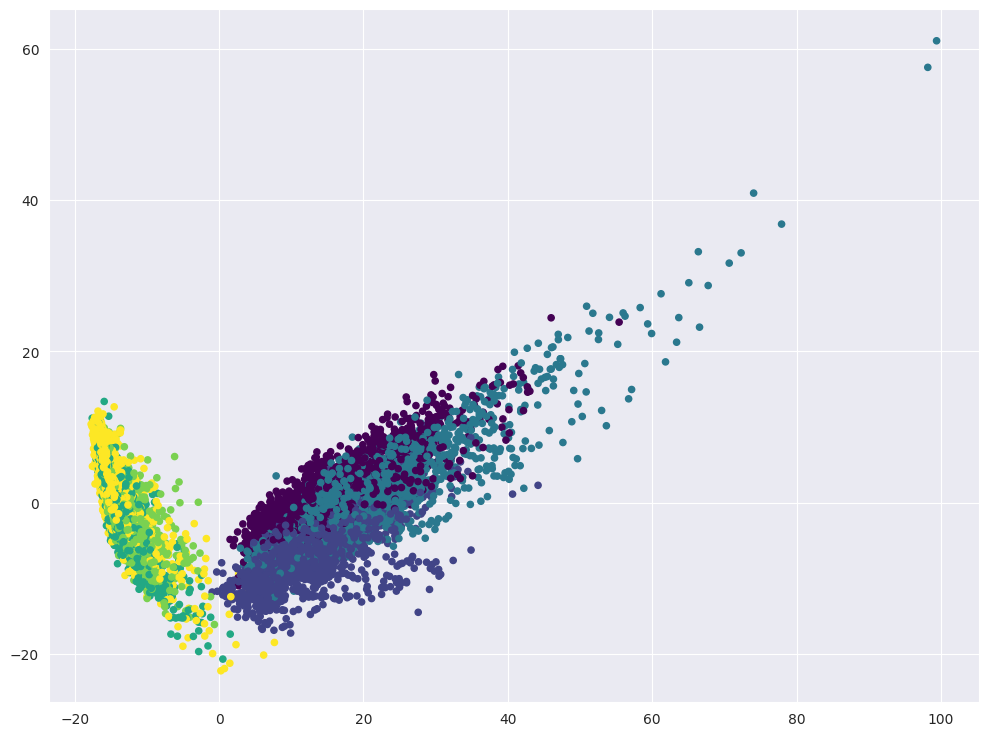

In [34]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')

**Вопрос 3:** (0.5 баллов)

Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

**Задание 1.** (1 балл)

Сделайте кластеризацию данных методом `KMeans` (собственная имплементация и готовая реализация), обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [ ]:
class MyKMeans:
    def __init__(self, n_clusters, n_init=100, random_state=42, 
                 max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.random_state = random_state
        self.max_iter = max_iter
        self.tol = tol
        
        # результаты
        self.cluster_centres_ = None
        self.labels_ = None
        self.inertia_ = None
        self.iterations_ = None
    
    def _init_centroids(self, X):
        np.random.seed(self.random_state)
        n_points, n_dims = X.shape
        
        centers = np.zeros((self.n_clusters, n_dims))
        centers[0] = X[np.random.randint(n_points)]
        
        for k in range(1, self.n_clusters):
            min_dists = []
            for x in X:
                distances = [np.sum((x - c) ** 2) for c in centers[:k]]
                min_dists.append(min(distances))
            
            probs = np.array(min_dists) / sum(min_dists)
            cum_probs = np.cumsum(probs)
            rand_val = np.random.rand()
            
            for idx, cp in enumerate(cum_probs):
                if rand_val < cp:
                    centers[k] = X[idx]
                    break
        
        return centers
    
    def _calc_inertia(self, X, assignments, centers):
        total = 0.0
        for k in range(self.n_clusters):
            cluster_data = X[assignments == k]
            if len(cluster_data) > 0:
                total += np.sum((cluster_data - centers[k]) ** 2)
        return total
    
    def _run_iterations(self, X, start_centers):
        centers = start_centers.copy()
        old_inertia = np.inf
        
        for it in range(self.max_iter):
            distances = np.zeros((X.shape[0], self.n_clusters))
            for k in range(self.n_clusters):
                diff = X - centers[k]
                distances[:, k] = np.sum(diff ** 2, axis=1)
            
            assignments = np.argmin(distances, axis=1)
            
            new_centers = np.zeros_like(centers)
            for k in range(self.n_clusters):
                cluster_points = X[assignments == k]
                if cluster_points.shape[0] > 0:
                    new_centers[k] = cluster_points.mean(axis=0)
                else:
                    new_centers[k] = X[np.random.choice(X.shape[0])]
            
            inertia_val = self._calc_inertia(X, assignments, new_centers)
            
            if np.abs(old_inertia - inertia_val) < self.tol:
                break
            
            centers = new_centers
            old_inertia = inertia_val
        
        return centers, assignments, inertia_val, it + 1
    
    def fit(self, X, y=None):
        X = np.array(X)
        n_points = X.shape[0]
        
        if n_points < self.n_clusters:
            raise ValueError(f"Точек ({n_points}) меньше чем кластеров ({self.n_clusters})")
        
        best_inertia = np.inf
        best_centroids = None
        best_assignments = None
        best_it_count = 0
        
        for _ in range(self.n_init):
            init_centroids = self._init_centroids(X)
            centroids, assignments, inertia_val, it_count = self._run_iterations(X, init_centroids)
            
            if inertia_val < best_inertia:
                best_inertia = inertia_val
                best_centroids = centroids
                best_assignments = assignments
                best_it_count = it_count
        
        self.cluster_centres_ = best_centroids
        self.labels_ = best_assignments
        self.inertia_ = best_inertia
        self.iterations_ = best_it_count
        
        return self
    
    def predict(self, X):
        if self.cluster_centres_ is None:
            raise Exception("Модель не обучена")
        
        X = np.array(X)
        n_points = X.shape[0]
        n_clusters = self.cluster_centres_.shape[0]
        
        distances = np.zeros((n_points, n_clusters))
        for k in range(n_clusters):
            diff = X - self.cluster_centres_[k]
            distances[:, k] = np.sum(diff ** 2, axis=1)
        
        return np.argmin(distances, axis=1)
    
    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.labels_
    
    def score(self, X):
        predictions = self.predict(X)
        return self._calc_inertia(X, predictions, self.cluster_centres_)

In [ ]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
X_class = kmeans.fit(X_pca)
labels = X_class.predict(X_pca)
kmeans.inertia_

2003454.8999158177

In [31]:
my_kmeans = MyKMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
my_kmeans.fit(X_pca)

mylables = my_kmeans.labels_
centers = my_kmeans.cluster_centres_
my_kmeans.inertia_

np.float64(2003454.798299288)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

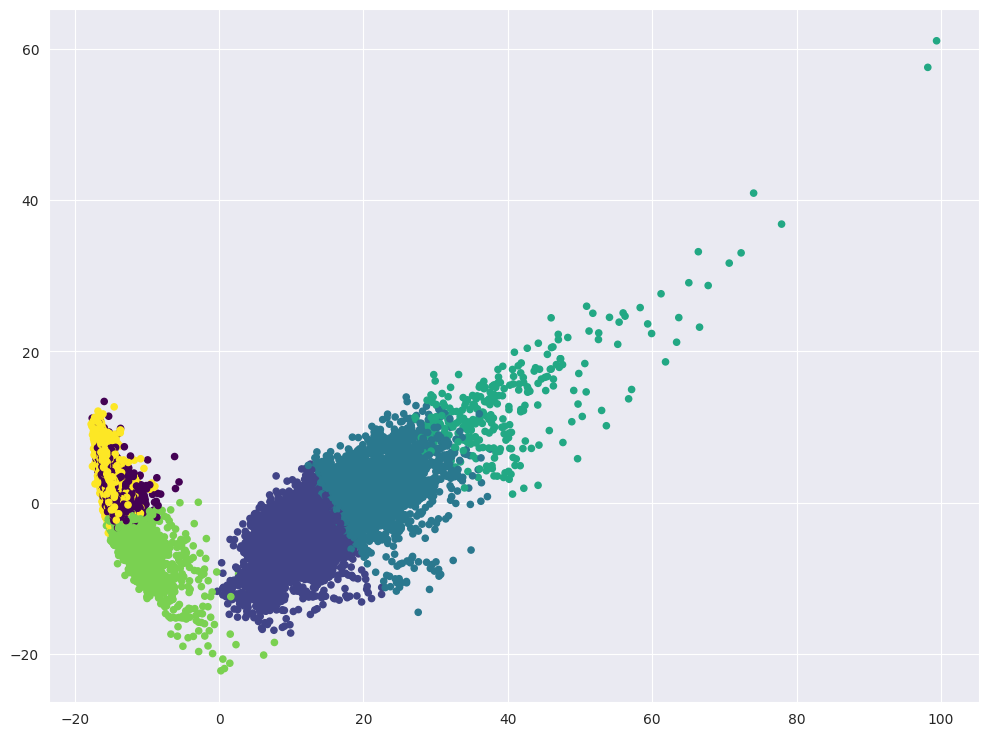

In [33]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=20,  cmap='viridis')

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [36]:
tab = pd.crosstab(y, labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице',
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,0,903,741,78,0,0,1722
подъем вверх по лестнице,0,1241,296,5,2,0,1544
спуск по лестнице,0,320,890,196,0,0,1406
сидение,1235,1,0,0,450,91,1777
стояние,1344,0,0,0,562,0,1906
лежание,52,5,0,0,329,1558,1944
все,2631,2470,1927,279,1343,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации.

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,

то такая доля будет 900 / 1406 $\approx$ 0.64.


**Вопрос 4:** (1 балл)

Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.








100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


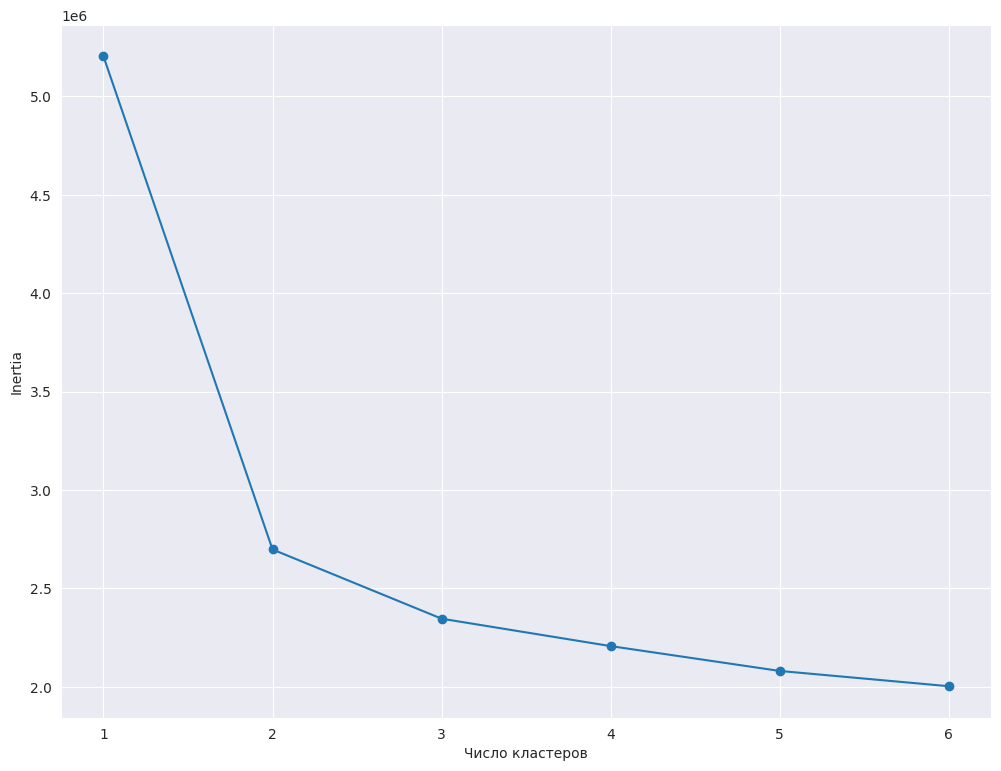

In [44]:
inertia = []
for k in tqdm.tqdm(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 9))
plt.plot(range(1, n_classes + 1), inertia, marker='o')
plt.xticks(range(1, n_classes + 1))
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')
plt.show()

**Вопрос 5:** (1 балл)

Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [45]:
ag = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [47]:
from sklearn.metrics import adjusted_rand_score 

print(f'AG: {adjusted_rand_score(y, ag.labels_)}')
print(f'KMeans: {adjusted_rand_score(y, labels)}')

AG: 0.49362763373004886
KMeans: 0.4198070012602345


**Вопрос 6:** (1 балл)

Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf).

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`.

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [51]:
gs = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
gs.fit(X_train_scaled, y_train,)
best_svc = gs.best_estimator_

In [54]:
print('Лучший гиперпараметр:', gs.best_params_)

Лучший гиперпараметр: {'C': 0.1}


**Вопрос 7** (0.5 баллов)

Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [55]:
y_predicted = best_svc.predict(X_test_scaled)

In [56]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице',
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,413,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,413,442,589,526,2947


**Вопрос 8:** (0.5 балл)

Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – сидение, по полноте – стояние**

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:** (1 балл)

Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


In [60]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f'Количество: {X_train_pca.shape[1]}')

Количество: 63


In [67]:
svc_pca = LinearSVC(random_state=RANDOM_STATE)
gs_pca = GridSearchCV(svc_pca, svc_params, cv=3)

gs_pca.fit(X_train_pca, y_train)

print(f'Лучший параметр для PCA: {gs_pca.best_params_}')
print(f"Лучшей скор на CV: {gs_pca.best_score_:.4f}")

score_full_features = gs.best_score_
score_pca_features = gs_pca.best_score_
difference = (score_full_features - score_pca_features) * 100

print(f'Качество на полных признаках: {score_full_features:.4f}')
print(f'Качество на PCA-признаках: {score_pca_features:.4f}')
print(f'Разница: {difference:.0f}%')

Лучший параметр для PCA: {'C': 0.1}
Лучшей скор на CV: 0.8984
Качество на полных признаках: 0.9380
Качество на PCA-признаках: 0.8984
Разница: 4%


**Вопрос 10:** (1 балл)

Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**

**Задание 2.** (1 балл)

Попробуйте использовать DBSCAN в качестве алгоритма кластеризации и метод понижения размерности tSNE.

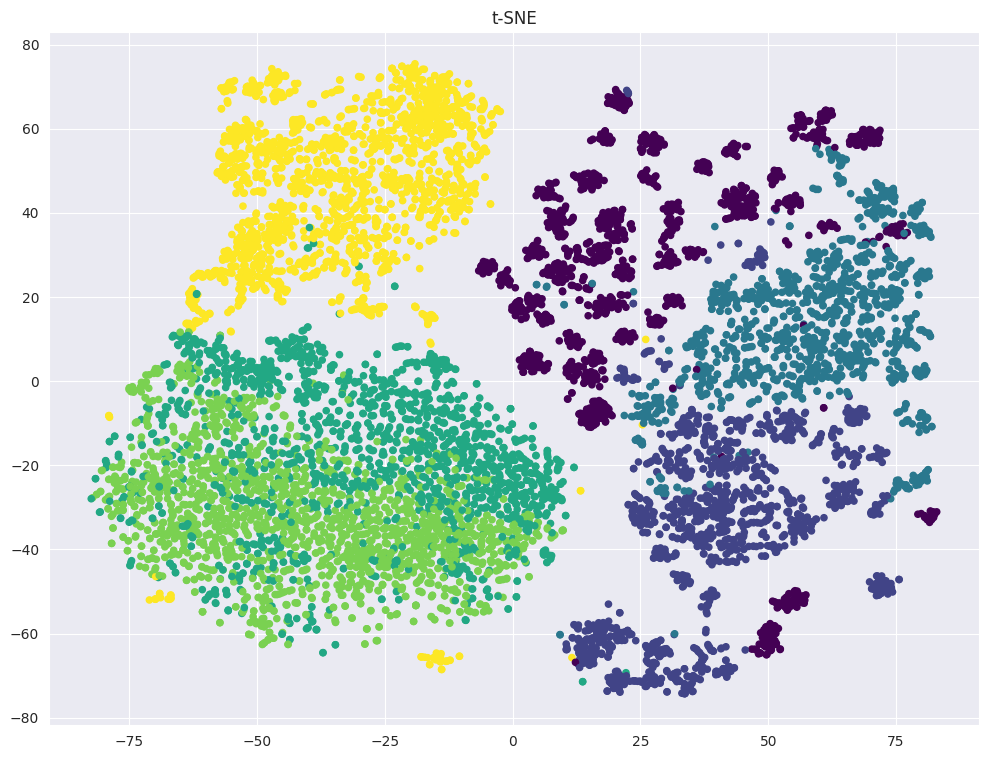

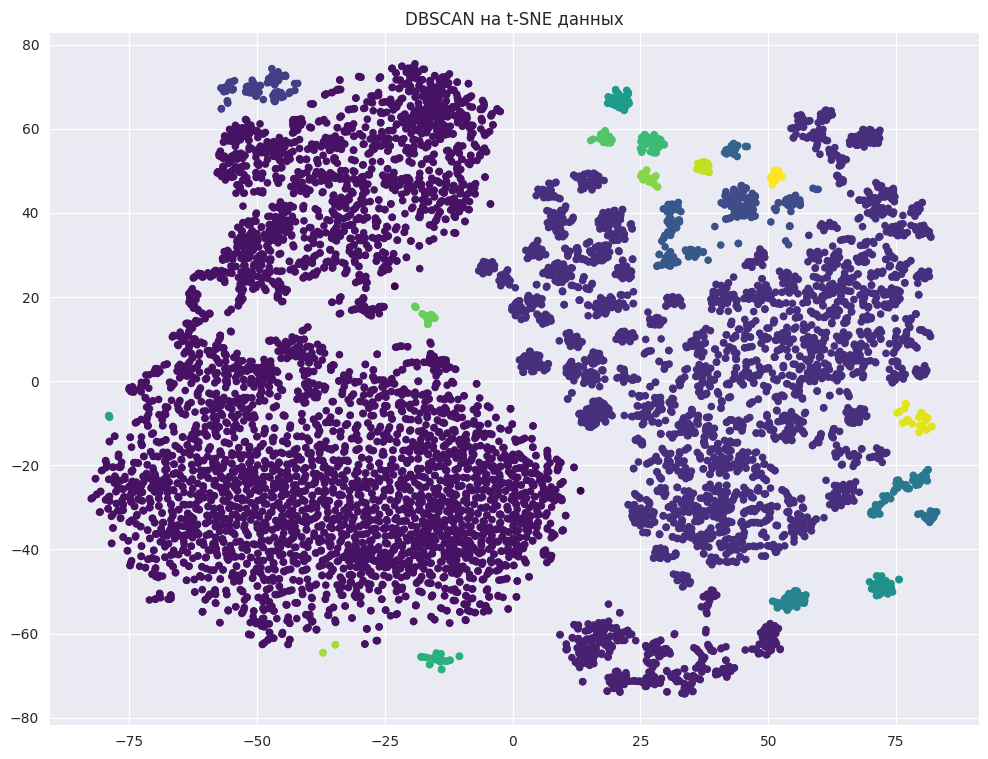

DBSCAN: 23 кластера


In [74]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, s=20, cmap='viridis')
plt.title('t-SNE')
plt.show()

dbscan = DBSCAN(eps=4., min_samples=4)
dbscan_labels = dbscan.fit_predict(X_tsne)

plt.figure(figsize=(12, 9))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan_labels, s=20, cmap='viridis')
plt.title('DBSCAN на t-SNE данных')
plt.show()

print(f'DBSCAN: {np.unique(dbscan_labels).size} кластера')